# Laboratorium

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
    
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < TOLERANCE:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        self.points = points
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    def get_points(self):
        return self.points
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Funkcje pomocniczne

In [2]:
# wyznacznik
def det3x3(p,q,r):
    return p[0]*q[1] + q[0]*r[1] + r[0]*p[1] - r[0]*q[1] - p[0]*r[1] - q[0]*p[1]

# plot added figure to lines
def polygon_to_lines(polygon):
    lines = []
    for i in polygon:
        lines.extend(i.lines)
    return lines

# lines to points
def lines_to_points(lines):
    points = []
    for i in lines:
        points.append(i[0])
    return points

from enum import Enum
class Vertex(Enum):
    START = 0
    END = 1
    SPLIT = 2
    MERGE = 3
    REGULAR = 4
    FIRST_CHAIN = 5
    SECOND_CHAIN = 6
    COMMON_CHAIN = 7



# make FIRST_CHAIN and SECOND_CHAIN , start and end vertices will have COMMON_CHAIN
def make_chains_vertices(types):
    n = len(types)
    order = [Vertex.COMMON_CHAIN for i in range(len(types))]
    i = 0
    while types[i] is not Vertex.START:
        i += 1
    i += 1
    while types[i%n] is not Vertex.END:
        order[i%n] = Vertex.FIRST_CHAIN
        i += 1
    i += 1
    while types[i%n] is not Vertex.START:
        order[i%n] = Vertex.SECOND_CHAIN
        i += 1
    return order

# array of 3 vertices 
def make_triangle(a,b,c):
    return [a,b,c]

# check if there can be diagonal between p and r
def is_inside(p,q,r, e = 10**(-13)):
    d = det3x3(p.v,q.v,r.v)        
    if r.chain is Vertex.SECOND_CHAIN:
        return d < -e
    else:
        return d > e

# Procedura sprawdzająca y - monotoniczność

In [3]:
def is_below(q,p): # is p below q
    return p[1] < q[1] or (p[1] == q[1] and p[0] > q[0])
def is_above(q,p): # is p above q
    return p[1] > q[1] or (p[1] == q[1] and p[0] < q[0])

def is_y_monotone(polygon, e = 10**(-13)):
    points = lines_to_points(polygon_to_lines(polygon))
    n = len(points)
    for i in range(2, n + 2):
        p = points[i-2]
        q = points[(i-1) % n]
        r = points[i % n]

        d = det3x3(p,q,r)
    
        if is_below(q,p) and is_below(q,r) and d < -e:
            return False # split vertice
        if is_above(q,p) and is_above(q,r) and d < -e:
            return False # merge vertice
        
    return True # if polygon doesn't have split and merge vertices then it is y-monotone

# Algorytm klasyfikacji wierzchołków

In [4]:


# make start, end , split, merge, regular vertices
def classificate_polygon_vertices(polygon, e = 10**(-13)):
    points = lines_to_points(polygon_to_lines(polygon))
    types = [0 for i in range(len(points))]
    
    n = len(points)
    for i in range(2, n + 2):
        p = points[i-2]
        q = points[(i-1) % n]
        r = points[i % n]

        d = det3x3(p,q,r)
    
        if is_below(q,p) and is_below(q,r):
            if d < -e:
                types[(i-1) % n] = Vertex.SPLIT
            else:
                types[(i-1) % n] = Vertex.START
        elif is_above(q,p) and is_above(q,r):
            if d < -e:
                types[(i-1) % n] = Vertex.MERGE
            else:
                types[(i-1) % n] = Vertex.END
        else:
            types[(i-1) % n] = Vertex.REGULAR
    return types

# plot start, end, split, merge, regular vertices
def plot_classificated_vertices(polygon, e = 10**(-13)):
    points = lines_to_points(polygon_to_lines(polygon))
    types = classificate_polygon_vertices(polygon, e)
    plot_ = Plot(scenes = [Scene(points = [PointsCollection([])],lines = [LinesCollection(polygon_to_lines(polygon))])])
    colors = ["green","red","darkblue","cyan","chocolate"]
    for i in range(len(points)):
        plot_.scenes[0].points.append(PointsCollection([points[i]],color=colors[types[i].value]))
    return plot_

# Algorytm triangulacji wielokąta y-monotonicznego

In [5]:
class Node:
    def __init__(self,v,type,chain):
        self.v = v
        self.type = type
        self.chain = chain
        
from functools import cmp_to_key
def triangulate(polygon, e = 10**(-13)):
    lines = polygon_to_lines(polygon)
    points = lines_to_points(lines)
    types = classificate_polygon_vertices(polygon,e)
    chains = make_chains_vertices(types)
    n = len(points)
    
    vertices = [Node(points[i],types[i],chains[i]) for i in range(n)]
    vertices.sort(reverse = True, key = lambda node : (node.v[1],-node.v[0]))
 
    rectangles = []
    diagonals = []
    stack = [vertices[0],vertices[1]]
    for i in range(2,n):
        if vertices[i].chain is Vertex.COMMON_CHAIN:
            for j in range(1,len(stack)-1):
                if det3x3(stack[-2].v,stack[-1].v,vertices[i].v) < -e:
                    rectangles.append(make_triangle(vertices[i].v,stack[j].v,stack[j-1].v))
                else:
                    rectangles.append(make_triangle(vertices[i].v,stack[j-1].v,stack[j].v))
                diagonals.append([vertices[i].v, stack[j].v])
            if det3x3(stack[-2].v,stack[-1].v,vertices[i].v) < -e:
                rectangles.append(make_triangle(vertices[i].v,stack[-1].v,stack[-2].v))
            else:
                rectangles.append(make_triangle(vertices[i].v,stack[-2].v,stack[-1].v))
        elif vertices[i].chain is not stack[-1].chain:
            for j in range(1,len(stack)):
                if det3x3(stack[-2].v,stack[-1].v,vertices[i].v) < -e:
                    rectangles.append(make_triangle(vertices[i].v,stack[j].v,stack[j-1].v))
                else:
                    rectangles.append(make_triangle(vertices[i].v,stack[j-1].v,stack[j].v))
                diagonals.append([vertices[i].v,stack[j].v])
            stack = [stack[-1],vertices[i]]
        else:
            
            while len(stack) >= 2 and is_inside(stack[-2],stack[-1],vertices[i], e):
                if det3x3(stack[-2].v,stack[-1].v,vertices[i].v) < -e:
                    rectangles.append(make_triangle(vertices[i].v,stack[-1].v,stack[-2].v))
                else:
                    rectangles.append(make_triangle(vertices[i].v,stack[-2].v,stack[-1].v))
                diagonals.append([vertices[i].v,stack[-2].v])
                stack.pop()
            stack.append(vertices[i])
            
            
    return [rectangles , diagonals]

# Funkcja rysująca kolejne kroki algorytmu (tworzone przekątne)

In [6]:
def plot_triangulate(polygon, e = 10**(-13)):
    lines = polygon_to_lines(polygon)
    points = lines_to_points(lines)
    types = classificate_polygon_vertices(polygon,e)
    chains = make_chains_vertices(types)
    n = len(points)
    
    vertices = [Node(points[i],types[i],chains[i]) for i in range(n)]
    vertices.sort(reverse = True, key = lambda node : (node.v[1],-node.v[0]))

    plot = Plot(scenes = [Scene(points = [PointsCollection(points.copy(),color="blue")],
                                lines = [LinesCollection(lines.copy(),color="blue")])])
    
    stack = [vertices[0],vertices[1]]
    points_calculated = []
    lines_calculated = []
    plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                   PointsCollection([vertices[0].v].copy(),color="red")],
                                   lines = [LinesCollection(lines.copy(),color="blue")]))
    points_calculated.append(vertices[0].v)
    plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                   PointsCollection(points_calculated.copy(),color="green"),
                                   PointsCollection([vertices[1].v].copy(),color="red")],
                                   lines = [LinesCollection(lines.copy(),color="blue")]))
    points_calculated.append(vertices[1].v)
    
    for i in range(2,n):
        plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                       PointsCollection(points_calculated.copy(),color="green"),
                                       PointsCollection([vertices[i].v].copy(),color="red")],
                               lines = [LinesCollection(lines.copy(),color="blue"),
                                        LinesCollection(lines_calculated.copy(),color="green")]))
        points_calculated.append(vertices[i].v)
        if vertices[i].chain is Vertex.COMMON_CHAIN:
            for j in range(1,(len(stack) - 1)):
                lines_calculated.append([vertices[i].v,stack[j].v])
                plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                               PointsCollection(points_calculated.copy(),color="green"),
                                               PointsCollection([vertices[i].v].copy(),color="red")],
                                   lines = [LinesCollection(lines.copy(),color="blue"),
                                            LinesCollection(lines_calculated.copy(), color="green")]))

        elif vertices[i].chain is not stack[-1].chain:
            for j in range(1,len(stack)):
                lines_calculated.append([vertices[i].v,stack[j].v])
                plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                               PointsCollection(points_calculated.copy(),color="green"),
                                               PointsCollection([vertices[i].v].copy(),color="red")],
                                   lines = [LinesCollection(lines.copy(),color="blue"),
                                            LinesCollection(lines_calculated.copy(), color="green")]))
            stack = [stack[-1],vertices[i]]
        else:
           
            while len(stack) >= 2 and is_inside(stack[-2],stack[-1],vertices[i]):
                lines_calculated.append([vertices[i].v,stack[-2].v])
                plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                               PointsCollection(points_calculated.copy(),color="green"),
                                               PointsCollection([vertices[i].v].copy(),color="red")],
                                     lines = [LinesCollection(lines.copy(),color="blue"),
                                              LinesCollection(lines_calculated.copy(), color="green")]))
                stack.pop()
            
            stack.append(vertices[i])
            
    plot.add_scene(Scene(points = [PointsCollection(points.copy(),color="blue"),
                                   PointsCollection(points_calculated.copy(),color="green")],
                         lines = [LinesCollection(lines.copy(),color="blue"),
                                  LinesCollection(lines_calculated.copy(), color="green")]))
    return plot


is y-monotone -  True


<IPython.core.display.Javascript object>


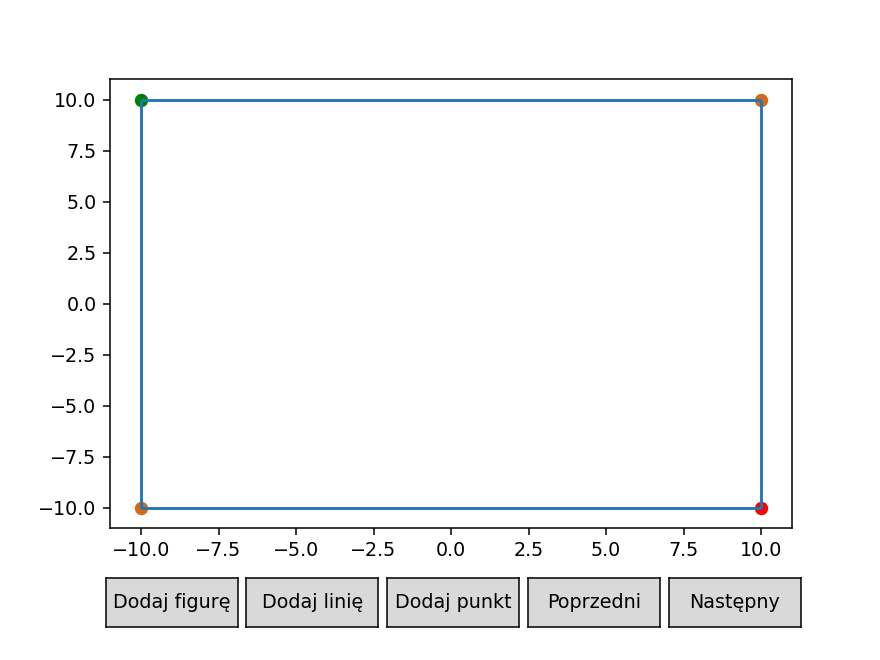

In [7]:
%matplotlib notebook
arrayA = []
verticeA = (-10,-10)

arrayA.append(LinesCollection([[verticeA,(-verticeA[0],verticeA[1])],
                              [(-verticeA[0],verticeA[1]),(-verticeA[0],-verticeA[1])],
                              [(-verticeA[0],-verticeA[1]),(verticeA[0],-verticeA[1])],
                              [(verticeA[0],-verticeA[1]),verticeA]]))
print("is y-monotone - ",is_y_monotone(arrayA))
square = plot_classificated_vertices(arrayA, e = 10**(-13))
square.draw()

Trójkąt nr 1 [(-10, -10), (10, 10), (-10, 10)]
Trójkąt nr 2 [(10, -10), (10, 10), (-10, -10)]
Przekątna nr 1 [(-10, -10), (10, 10)]


<IPython.core.display.Javascript object>


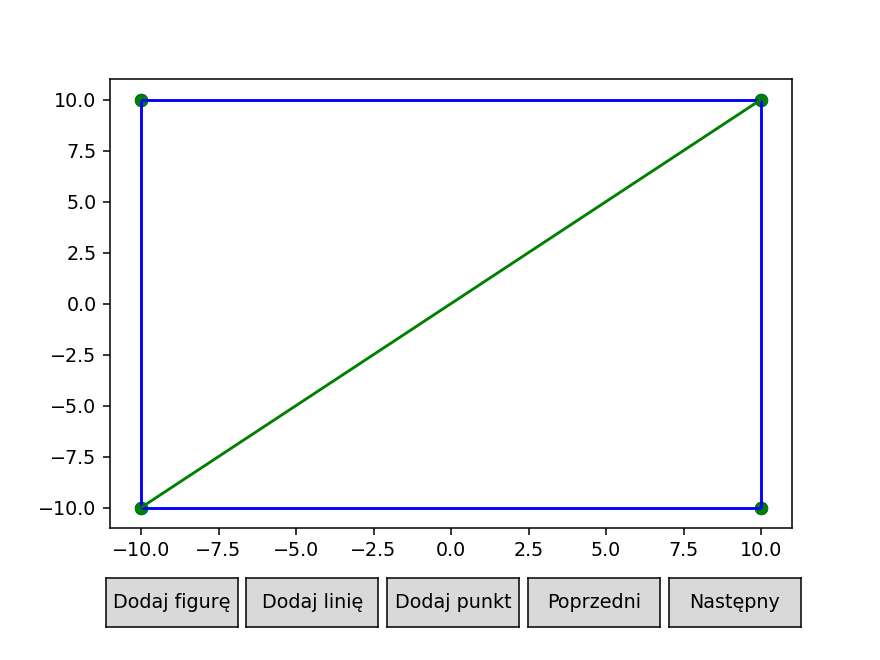

In [8]:
%matplotlib notebook
triangulated_square = triangulate(arrayA)
for i in range(len(triangulated_square[0])):
    print("Trójkąt nr",i+1,triangulated_square[0][i])
for i in range(len(triangulated_square[1])):
    print("Przekątna nr",i+1,triangulated_square[1][i])
plot_square = plot_triangulate(arrayA)
plot_square.draw()

# Trójkąt

is y-monotone -  True


<IPython.core.display.Javascript object>


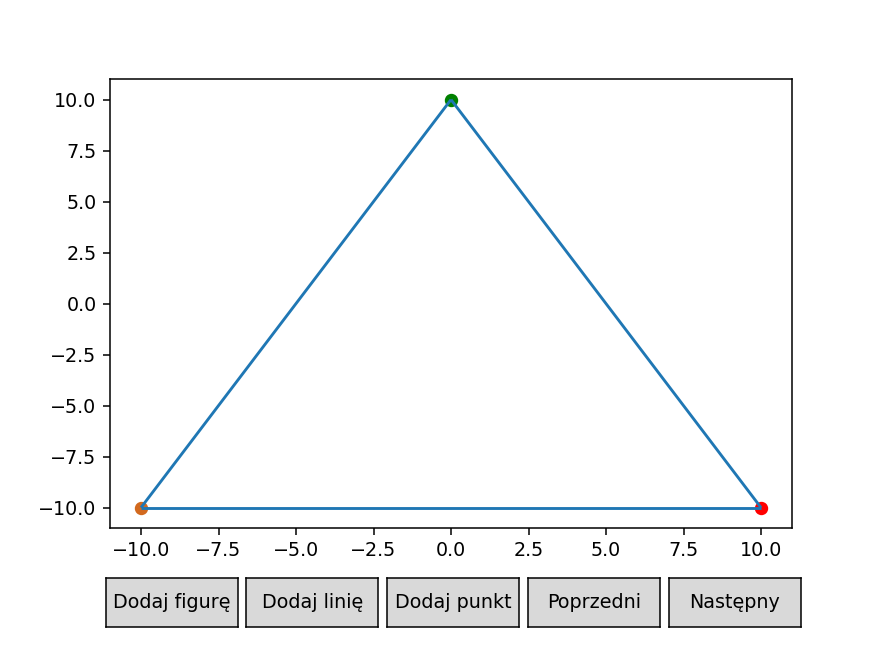

In [9]:
%matplotlib notebook
arrayB = []
verticeB1 = (-10,-10)
verticeB2 = (10,-10)
verticeB3 = (0,10)

arrayB.append(LinesCollection([[verticeB1,verticeB2],
                              [verticeB2,verticeB3],
                              [verticeB3,verticeB1]]))
print("is y-monotone - ",is_y_monotone(arrayB))
triangle = plot_classificated_vertices(arrayB, e = 10**(-13))
triangle.draw()

Trójkąt nr 1 [(10, -10), (0, 10), (-10, -10)]


<IPython.core.display.Javascript object>


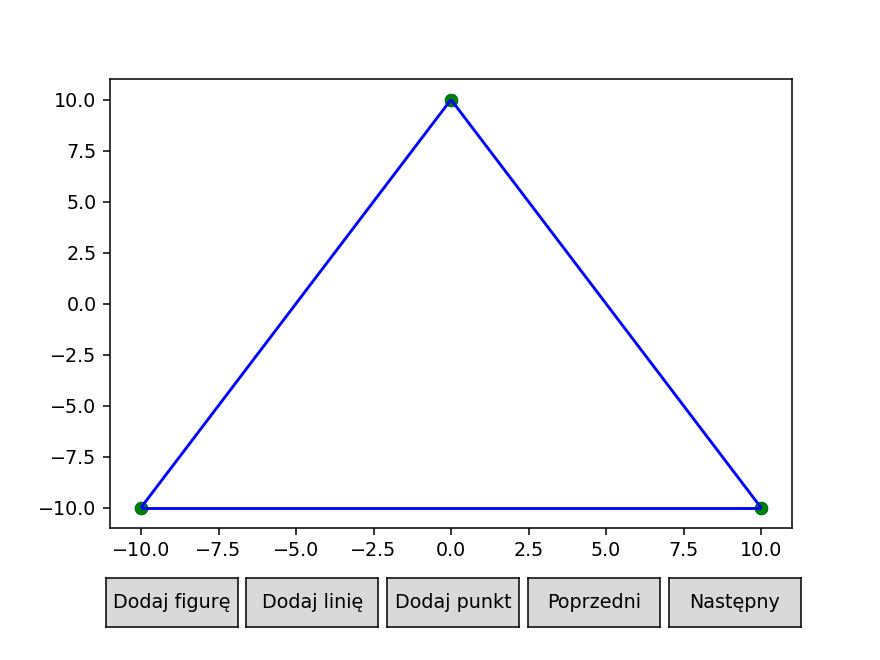

In [10]:
%matplotlib notebook
triangulated_triangle = triangulate(arrayB)
for i in range(len(triangulated_triangle[0])):
    print("Trójkąt nr",i+1,triangulated_triangle[0][i])
for i in range(len(triangulated_triangle[1])):
    print("Przekątna nr",i+1,triangulated_triangle[1][i])
plot_triangle = plot_triangulate(arrayB)
plot_triangle.draw()

# Narysuj wielokąt y-monotoniczny

<IPython.core.display.Javascript object>


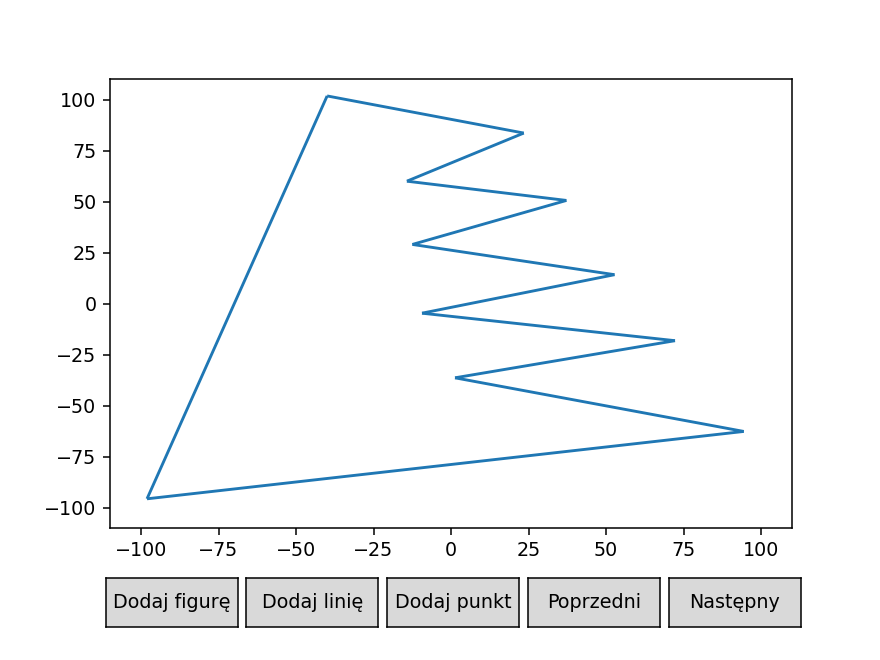

In [11]:
%matplotlib notebook
plot = Plot(scenes = [Scene(points = [PointsCollection([(-100,-100),(100,100)],color="white")])])
plot.draw()

# Wynik

is y-monotone -  True


<IPython.core.display.Javascript object>


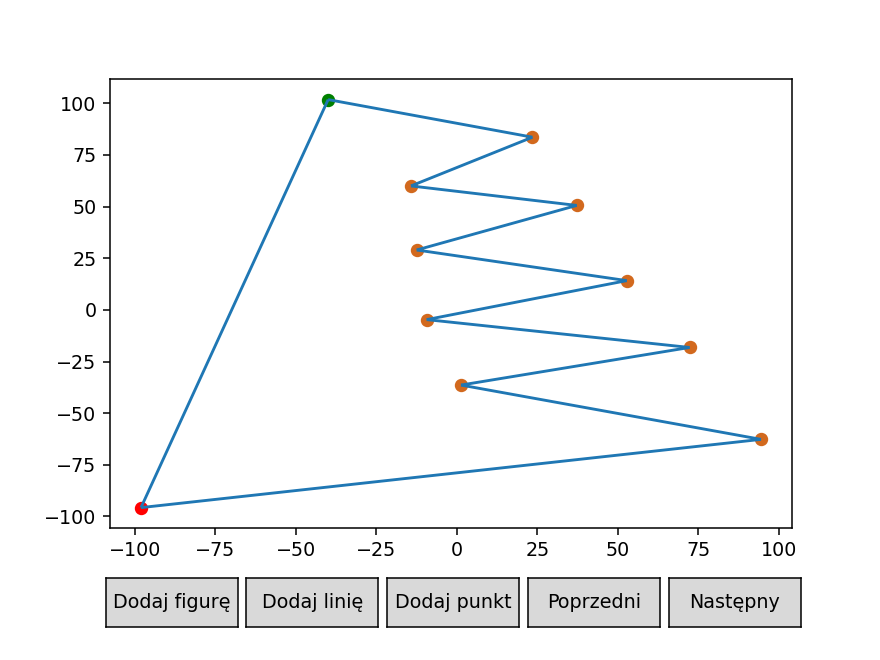

In [12]:
%matplotlib notebook
polygon = plot.get_added_figure()
print("is y-monotone - ",is_y_monotone(polygon))
plot1 = plot_classificated_vertices(polygon, e = 10**(-13))
plot1.draw()

Trójkąt nr 1 [(-14.228836797898822, 60.00613212585449), (23.47277610532697, 83.59681840036433), (-39.95464324951173, 101.79534781212902)]
Trójkąt nr 2 [(-12.454643249511747, 29.001230165070183), (37.22277610532697, 50.56985761605057), (-14.228836797898822, 60.00613212585449)]
Trójkąt nr 3 [(-12.454643249511747, 29.001230165070183), (-14.228836797898822, 60.00613212585449), (-39.95464324951173, 101.79534781212902)]
Trójkąt nr 4 [(-9.34980453983431, -4.699750227086696), (52.746969653714075, 14.17279879252115), (-12.454643249511747, 29.001230165070183)]
Trójkąt nr 5 [(-9.34980453983431, -4.699750227086696), (-12.454643249511747, 29.001230165070183), (-39.95464324951173, 101.79534781212902)]
Trójkąt nr 6 [(1.2953567504882528, -36.378671795714155), (72.26309868597212, -18.18014238394943), (-9.34980453983431, -4.699750227086696)]
Trójkąt nr 7 [(-98.05948195918916, -95.69239728591025), (-9.34980453983431, -4.699750227086696), (-39.95464324951173, 101.79534781212902)]
Trójkąt nr 8 [(-98.059481

<IPython.core.display.Javascript object>


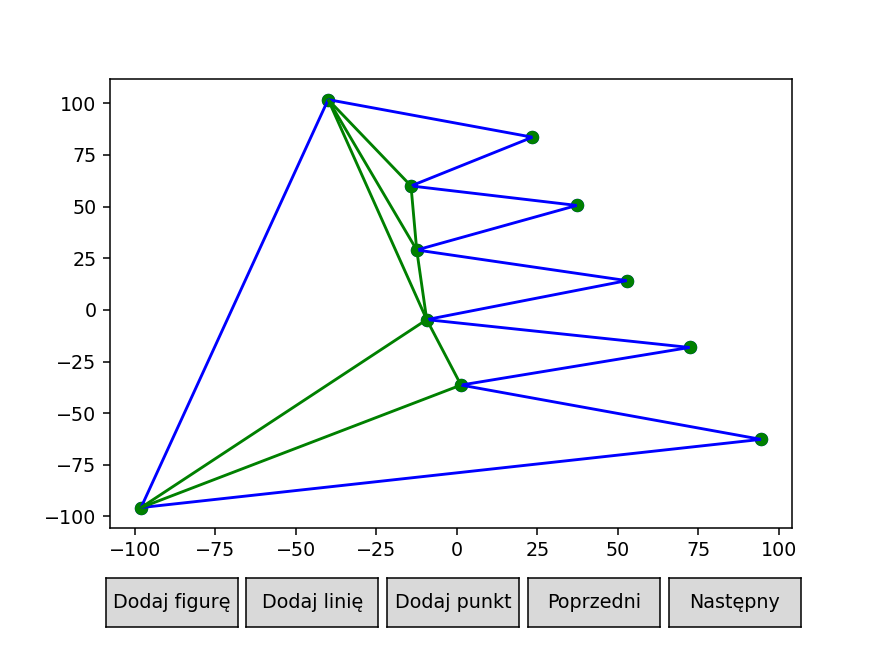

In [13]:
%matplotlib notebook
triangulated_polygon = triangulate(polygon)
for i in range(len(triangulated_polygon[0])):
    print("Trójkąt nr",i+1,triangulated_polygon[0][i])
for i in range(len(triangulated_polygon[1])):
    print("Przekątna nr",i+1,triangulated_polygon[1][i])
plot_polygon = plot_triangulate(polygon)
plot_polygon.draw()